In [45]:
import pandas as pd, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
import sys
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.metrics import log_loss
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import precision_recall_curve


df = pd.read_csv('/Users/taehyun/Dropbox/Springboard/Projects/airport-codes/data/df_modeling.csv').iloc[:,2:]
df.continent.replace(np.nan, 'NA',inplace=True)
df.head()

,type,elevation_ft,continent,Longitude
0,heliport,11.0,NA,-74.933601
1,small_airport,3435.0,NA,-101.473911
2,small_airport,450.0,NA,-151.695999
3,small_airport,820.0,NA,-86.770302
4,small_airport,1100.0,NA,-97.818019


We will encode the categorical features in x with binary encoder

In [46]:
def form_x_y(data):    
    X = data.drop(['type'], axis =1 )
    y = data['type']
    return X, y
    
def train_val_test_split(x,y):
    test_size = 0.5
    X_train, X_vem, y_train, y_vem = train_test_split(x,y, train_size = 0.8, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_vem, y_vem , test_size = 0.5, random_state =42)
    return X_train, y_train, X_val, X_test, y_val, y_test

def concat_values(x):
    counts = x.continent.value_counts()
    mask = x['continent'].isin(counts[counts < 3000].index)
    x['continent'][mask] = 'other'
    return x
    
def encode(train, val, test):    
    encoder = ce.BinaryEncoder(cols = 'continent')
    X_train_encoded = pd.DataFrame(encoder.fit_transform(train['continent']))
    X_val_encoded = pd.DataFrame(encoder.transform(val['continent']))
    X_test_encoded = pd.DataFrame(encoder.transform(test['continent']))
    
    new_df = pd.concat([X_train_encoded, train], axis = 1)
    new_df2 = pd.concat([X_val_encoded, val], axis = 1)
    new_df3 = pd.concat([X_test_encoded, test], axis = 1)
    
    new_df = new_df.drop(['continent'], axis=1)
    new_df2 = new_df2.drop(['continent'], axis=1)
    new_df3 = new_df3.drop(['continent'], axis=1)
    
    new_df = new_df.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})
    new_df2 = new_df2.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})
    new_df3 = new_df3.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})

    return new_df, new_df2, new_df3
    
    
def scale_data(train,val,test):
    ss = StandardScaler()
    train[['elevation_ft','longitude']]= ss.fit_transform(train[['elevation_ft','longitude']])
    val[['elevation_ft','longitude']] = ss.transform(val[['elevation_ft','longitude']])
    test[['elevation_ft','longitude']] = ss.transform(test[['elevation_ft','longitude']])


1. Limiting your Columns
    - There are way too less values for A,CA,AN. So we can make mask these as other instead of including in our encoding process.
2. make x,y
3. split data
4. encode categorical features in x
5. scale x

In [47]:
X,y = form_x_y(df)
print(X.shape)
print(y.shape)

(46875, 3)
(46875,)


In [48]:
X = concat_values(X)
X.continent.value_counts()

/var/folders/z3/37b1tph56lbflqsnd5zj_8lh0000gn/T/ipykernel_44851/1231073937.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['continent'][mask] = 'other'


NA       25017
SA        8143
other     8118
EU        5597
Name: continent, dtype: int64

In [49]:
X_train, y_train, X_val, X_test, y_val, y_test = train_val_test_split(X,y)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(37500, 3)
(37500,)
(4687, 3)
(4687,)
(4688, 3)
(4688,)


In [51]:
X_train, X_val, X_test = encode(X_train, X_val, X_test)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37500, 5)
(4687, 5)
(4688, 5)


In [52]:
scale_data(X_train,X_val,X_test)

# For each Classifier, Bayesiam Optimization is performed using Optuna. 

I chose 3 types of boosting models because of its robustness. It learns the dataset with multiple models that can learn sequentially which drastically decreases the error rate. In addition, since I have a lot of samples and not that many features, it fits the criteria for fitting the boosting models. I chose 3 different boosting models to compare its performance and running time. The expected overall performance would be ranked as the following: 1.Catboost 2.LGBM Classifier 3. Ada Boost

In [53]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear', gamma = 'scale', random_state =0)
start = time.time()
clf.fit(X_train,y_train)
stop = time.time()

stop-start

24.049245834350586

# LGBM Classifier

In [54]:
model_scores = []
bayesian_optimization_time = []

In [55]:
def objective(trial):
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = LGBMClassifier(**params_lgb)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    
    return log_score

In [56]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

#Append it in the list that gathers scores
model_scores.append(study.best_value)

[I 2022-10-11 09:13:09,136] A new study created in memory with name: lgbm_parameter_opt
[I 2022-10-11 09:13:15,171] Trial 0 finished with value: 0.7895332722264198 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7895332722264198.
[I 2022-10-11 09:13:19,753] Trial 1 finished with value: 0.6880233887925314 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.6880233887925314.
[I 2022-10-11 09:13:24,140] Trial 2 finished with value: 0.6844388964415891 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.6811404752677401
Best trial: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}


In [57]:
bayesian_optimization_time.append(58)

Took 58 second to find the best parameter

# AdaBoostClassifier

In [58]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    params_lgb = {
        'learning_rate' : trial.suggest_float('learning_rate', 0.01,0.1),
        'n_estimators' : trial.suggest_int('n_estimators', 1,10),
        'algorithm' : 'SAMME.R'
    }

    model = AdaBoostClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train
    )

    lgb_pred = model.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    
    return log_score

In [59]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="adab_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

model_scores.append(study.best_value)

[I 2022-10-11 09:14:14,114] A new study created in memory with name: adab_parameter_opt
[I 2022-10-11 09:14:14,848] Trial 0 finished with value: 0.8850123863712076 and parameters: {'learning_rate': 0.04370861069626263, 'n_estimators': 10}. Best is trial 0 with value: 0.8850123863712076.
[I 2022-10-11 09:14:15,281] Trial 1 finished with value: 0.8844910863633713 and parameters: {'learning_rate': 0.07587945476302646, 'n_estimators': 6}. Best is trial 1 with value: 0.8844910863633713.
[I 2022-10-11 09:14:15,449] Trial 2 finished with value: 0.8913461360249704 and parameters: {'learning_rate': 0.02404167763981929, 'n_estimators': 2}. Best is trial 1 with value: 0.8844910863633713.
[I 2022-10-11 09:14:16,083] Trial 3 finished with value: 0.88244223480024 and parameters: {'learning_rate': 0.015227525095137952, 'n_estimators': 9}. Best is trial 3 with value: 0.88244223480024.
[I 2022-10-11 09:14:16,655] Trial 4 finished with value: 0.8876932663961226 and parameters: {'learning_rate': 0.064100

Best Score: 0.8791654869393893
Best trial: {'learning_rate': 0.048875051677790424, 'n_estimators': 3}


In [60]:
bayesian_optimization_time.append(3)

# Cat boost

In [61]:
def class_weights():
    NA_weight = round(1 - (X.continent.value_counts()[0] / X.continent.value_counts().sum()),2)
    SA_weight = round(1 - (X.continent.value_counts()[1] / X.continent.value_counts().sum()),2)
    A_CA_AN_OC_AS_AF_weight = round(1 - (X.continent.value_counts()[2] / X.continent.value_counts().sum()),2)
    EU_weight = round(1 - (X.continent.value_counts()[3] / X.continent.value_counts().sum()),2)
    
    return NA_weight, SA_weight, A_CA_AN_OC_AS_AF_weight, EU_weight
    

In [62]:
class_weights()

(0.47, 0.83, 0.83, 0.88)

In [63]:
def ridge_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    max_depth = trial.suggest_int('max_depth',2,18)

    cb = CatBoostClassifier(learning_rate=learning_rate, random_state=42, loss_function = 'MultiClass', class_weights = [0.47, 0.83, 0.83, 0.94], n_estimators = n_estimators,
                           max_depth = max_depth)
    # Calculate the score with 10-folds cross validation, which returns a list of scores
    # scoring is defined as negative RMSE as it is what this Kaggle competition uses to evaluate the result
    cb.fit(X_train,y_train)
    
    lgb_pred = cb.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    # Return the mean of 10 scores
    return log_score

In [64]:
study = optuna.create_study(direction="minimize")
study.optimize(ridge_objective, n_trials=3)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

model_scores.append(study.best_value)

[I 2022-10-11 09:14:18,522] A new study created in memory with name: no-name-7e761e17-0396-412c-bf9e-5cd46ee9b1e2


0:	learn: 1.2990119	total: 9.31ms	remaining: 3.74s
1:	learn: 1.2270645	total: 18.2ms	remaining: 3.65s
2:	learn: 1.1660525	total: 27.4ms	remaining: 3.66s
3:	learn: 1.1136423	total: 36.3ms	remaining: 3.62s
4:	learn: 1.0698065	total: 45.4ms	remaining: 3.61s
5:	learn: 1.0319791	total: 55.1ms	remaining: 3.64s
6:	learn: 0.9985281	total: 64ms	remaining: 3.62s
7:	learn: 0.9672162	total: 75.2ms	remaining: 3.71s
8:	learn: 0.9407828	total: 84.5ms	remaining: 3.7s
9:	learn: 0.9183591	total: 94.5ms	remaining: 3.71s
10:	learn: 0.8972312	total: 104ms	remaining: 3.69s
11:	learn: 0.8784989	total: 112ms	remaining: 3.66s
12:	learn: 0.8620886	total: 121ms	remaining: 3.63s
13:	learn: 0.8472972	total: 129ms	remaining: 3.59s
14:	learn: 0.8327316	total: 137ms	remaining: 3.55s
15:	learn: 0.8208191	total: 146ms	remaining: 3.54s
16:	learn: 0.8080440	total: 154ms	remaining: 3.5s
17:	learn: 0.7979606	total: 162ms	remaining: 3.46s
18:	learn: 0.7889313	total: 169ms	remaining: 3.42s
19:	learn: 0.7790959	total: 176ms	r

[I 2022-10-11 09:14:22,377] Trial 0 finished with value: 0.736793940816879 and parameters: {'learning_rate': 0.05952908053496482, 'n_estimators': 403, 'max_depth': 4}. Best is trial 0 with value: 0.736793940816879.


0:	learn: 1.3526719	total: 12.9ms	remaining: 6.08s
1:	learn: 1.3219019	total: 26.2ms	remaining: 6.15s
2:	learn: 1.2931757	total: 33.6ms	remaining: 5.24s
3:	learn: 1.2654816	total: 44ms	remaining: 5.14s
4:	learn: 1.2390136	total: 55.2ms	remaining: 5.14s
5:	learn: 1.2151968	total: 64.2ms	remaining: 4.97s
6:	learn: 1.1925782	total: 78.5ms	remaining: 5.2s
7:	learn: 1.1712797	total: 92.9ms	remaining: 5.37s
8:	learn: 1.1514185	total: 105ms	remaining: 5.38s
9:	learn: 1.1330532	total: 112ms	remaining: 5.17s
10:	learn: 1.1146996	total: 125ms	remaining: 5.21s
11:	learn: 1.0976357	total: 134ms	remaining: 5.11s
12:	learn: 1.0817162	total: 141ms	remaining: 4.97s
13:	learn: 1.0661907	total: 153ms	remaining: 5.01s
14:	learn: 1.0514649	total: 165ms	remaining: 5.02s
15:	learn: 1.0377554	total: 173ms	remaining: 4.91s
16:	learn: 1.0238914	total: 185ms	remaining: 4.93s
17:	learn: 1.0106596	total: 196ms	remaining: 4.93s
18:	learn: 0.9981172	total: 209ms	remaining: 4.97s
19:	learn: 0.9864957	total: 222ms	re

[I 2022-10-11 09:14:28,181] Trial 1 finished with value: 0.7434420376186341 and parameters: {'learning_rate': 0.022110449031161092, 'n_estimators': 471, 'max_depth': 7}. Best is trial 0 with value: 0.736793940816879.


466:	learn: 0.6042290	total: 5.48s	remaining: 46.9ms
467:	learn: 0.6041589	total: 5.49s	remaining: 35.2ms
468:	learn: 0.6040957	total: 5.5s	remaining: 23.4ms
469:	learn: 0.6040491	total: 5.51s	remaining: 11.7ms
470:	learn: 0.6039686	total: 5.52s	remaining: 0us
0:	learn: 1.3222888	total: 14.2ms	remaining: 4.57s
1:	learn: 1.2660899	total: 31ms	remaining: 4.98s
2:	learn: 1.2177240	total: 40.1ms	remaining: 4.28s
3:	learn: 1.1751215	total: 48.6ms	remaining: 3.87s
4:	learn: 1.1363677	total: 60.7ms	remaining: 3.86s
5:	learn: 1.1008821	total: 75.5ms	remaining: 3.99s
6:	learn: 1.0696037	total: 85.9ms	remaining: 3.88s
7:	learn: 1.0416264	total: 93.3ms	remaining: 3.67s
8:	learn: 1.0168284	total: 98.8ms	remaining: 3.45s
9:	learn: 0.9918683	total: 118ms	remaining: 3.68s
10:	learn: 0.9706988	total: 126ms	remaining: 3.58s
11:	learn: 0.9507775	total: 145ms	remaining: 3.76s
12:	learn: 0.9316801	total: 173ms	remaining: 4.12s
13:	learn: 0.9157247	total: 179ms	remaining: 3.95s
14:	learn: 0.8986439	total: 

[I 2022-10-11 09:14:35,025] Trial 2 finished with value: 0.7232695386358172 and parameters: {'learning_rate': 0.0425403534378164, 'n_estimators': 323, 'max_depth': 10}. Best is trial 2 with value: 0.7232695386358172.


321:	learn: 0.5825479	total: 6.62s	remaining: 20.5ms
322:	learn: 0.5824336	total: 6.64s	remaining: 0us
Best Score: 0.7232695386358172
Best trial: {'learning_rate': 0.0425403534378164, 'n_estimators': 323, 'max_depth': 10}


In [65]:
bayesian_optimization_time.append(38)

In [66]:
model_scores

[0.6811404752677401, 0.8791654869393893, 0.7232695386358172]

# Notice the evaluation metrics to choose the best model was log loss. Therefore, the lower the score, the better the model performed

In [80]:
result_df = pd.DataFrame({'log loss scores': model_scores, 'bayesian_optimization_time':bayesian_optimization_time}, index = ['LGBM classifier', 'Ada boost', 'Cat boost'])
result_df.to_csv('/users/taehyun/Dropbox/Springboard/Projects/airport-codes/images/result_df.csv') 


I used log loss so less the score, the better. Therefore, Ligh XGBM is the winner! let's use this model to train with the best parameters.

In [68]:
LGBM = LGBMClassifier(reg_alpha= 1.7560829253683595e-07, reg_lambda= 0.07339153040632079, max_depth=15, num_leaves= 187, colsample_bytree = 0.8627622080115674, subsample= 0.35183125621386324, subsample_freq =4,min_child_samples= 16, max_bin= 459)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)
y_pred_prob = LGBM.predict_proba(X_test)

print(classification_report(y_pred,y_test))

                precision    recall  f1-score   support

      heliport       0.43      0.59      0.50       737
medium_airport       0.15      0.36      0.21       149
 seaplane_base       0.21      0.52      0.30        61
 small_airport       0.90      0.76      0.82      3741

      accuracy                           0.72      4688
     macro avg       0.42      0.56      0.46      4688
  weighted avg       0.79      0.72      0.75      4688



In [69]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

def plotconfusionmatrix(y1,y2):
    cm = confusion_matrix(y1,y2)

    cm_df = pd.DataFrame(cm, index = ['heliport','medium_airport','seaplane_base','small_airport'],
                        columns = ['heliport','medium_airport','seaplane_base','small_airport'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, )
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()


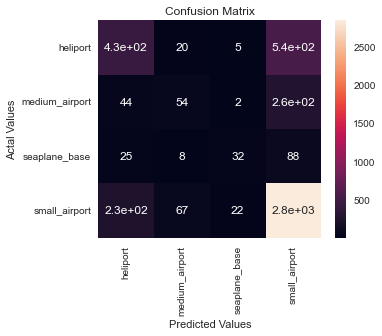

In [78]:
plotconfusionmatrix(y_test,y_pred)
plt.savefig('/users/taehyun/Dropbox/Springboard/Projects/airport-codes/images/Confusion_matrix.jpeg',bbox_inches='tight') 

micro would be better than other options for average parameter since the data is imbalanced.

In [71]:
print(f"Training score: {round(LGBM.score(X_train, y_train),2)}")
print(f"Training score: {round(LGBM.score(X_test, y_test),2)}")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred, average = 'micro'), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred,average = 'micro'), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred,average = 'micro'), 2)}")
print(f"log_loss: {round(log_loss(y_test, y_pred_prob),2)}")

Training score: 0.79
Training score: 0.72
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1_score: 0.72
log_loss: 0.75


# Roc_Auc_score

In [72]:
def multiclass_roc_auc_score_macro(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [73]:
def multiclass_roc_auc_score_micro(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [74]:
multiclass_roc_auc_score_macro(y_test, y_pred)

0.6233392606223855

In [75]:
multiclass_roc_auc_score_micro(y_test, y_pred)

0.8115756541524459

# Plotting ROC curve

In [76]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=["small_airport", "heliport","medium_airport","seaplane_base"])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

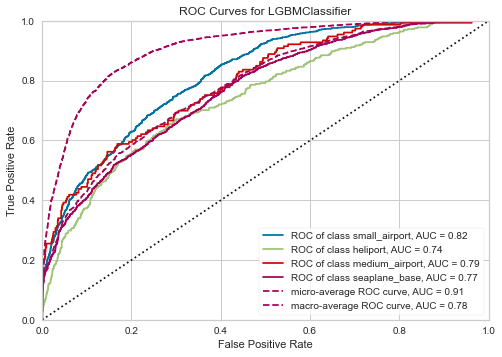

In [77]:
plot_ROC_curve(LGBM, X_train, y_train, X_test, y_test)
plt.show()      

# Take Aways 


• The following two points were the main reason I chose F1, Precision-Recall curve and PR AUC.   
    • First of all, you shouldn’t use accuracy on imbalanced problems. Because if you use it, it is easy to get a high accuracy score by simply classifying all observations as the majority class.

    • The roc-auc metric can't be used when your data is heavily imbalanced.

• Therefore, if the dataset is heavily imbalanced and/or you mostly care about the positive class, I’d consider using F1 score, or Precision-Recall curve and PR AUC. The additional reason to go with F1 (or Fbeta) is that these metrics are easier to interpret and communicate to business stakeholders.

• LGBM classifier is the best model to predict the airport.
        • The metric that I used to determine the best model is log loss.

LGBM classifier -> 0.681140
Ada boost -> 0.905043
Cat boost -> 0.702763



Small aiports are usually private flight stuff. So since it is built on top of buildings like private jets, It makes sense that it has the highest altitude.